# Protein-mRNA Dataset Processor

This notebook processes the protein-mRNA sequence dataset and organizes it for training conditional GFlowNets with protein sequence conditioning.


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [72]:
def dna_to_mrna(dna_sequence: str) -> str:
    """Convert DNA sequence to mRNA by replacing T with U."""
    return dna_sequence.upper().replace('T', 'U')

def clean_sequence(sequence: str) -> str:
    cleaned = sequence.replace(' ', '').upper()
    return cleaned

def get_sequence_length_category(length: int) -> str:
    if length < 100:
        return "Very Short"
    elif length < 300:
        return "Short"
    elif length < 600:
        return "Medium"
    elif length < 1000:
        return "Long"
    else:
        return "Very Long"

In [73]:
print("Loading dataset...")
df = pd.read_csv('Protein_mRNA_sequence_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Loading dataset...
Dataset shape: (3804, 3)
Columns: ['protein_sequence', 'coding_sequence', 'info']


In [74]:
processed_df = df.copy()

# Clean and convert DNA to mRNA
processed_df['coding_sequence_clean'] = processed_df['coding_sequence'].apply(clean_sequence)
processed_df['mrna_sequence'] = processed_df['coding_sequence_clean'].apply(dna_to_mrna)

# Calculate sequence lengths
processed_df['protein_length'] = processed_df['protein_sequence'].str.len()
processed_df['mrna_length'] = processed_df['mrna_sequence'].str.len()

# Add length categories
processed_df['protein_length_category'] = processed_df['protein_length'].apply(get_sequence_length_category)
processed_df['mrna_length_category'] = processed_df['mrna_length'].apply(get_sequence_length_category)

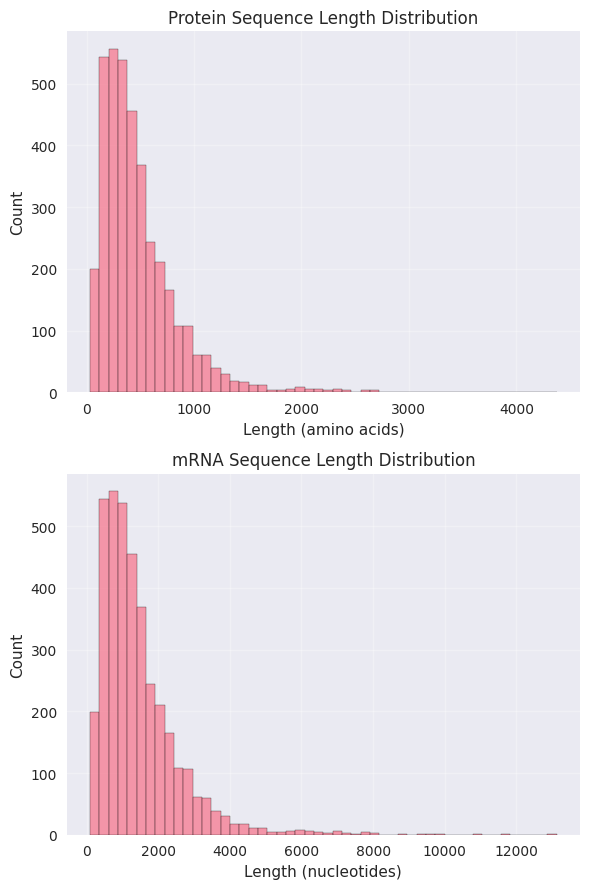

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(6, 9))

# 1. Protein length distribution
axes[0].hist(processed_df['protein_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Protein Sequence Length Distribution')
axes[0].set_xlabel('Length (amino acids)')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# 2. mRNA length distribution
axes[1].hist(processed_df['mrna_length'], bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('mRNA Sequence Length Distribution')
axes[1].set_xlabel('Length (nucleotides)')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [76]:
# Sort by protein length (short to long)
sorted_df = processed_df.sort_values('protein_length').reset_index(drop=True)

In [77]:
print(f"Shortest protein: {sorted_df.iloc[0]['protein_length']} amino acids")
print(f"Longest protein: {sorted_df.iloc[-1]['protein_length']} amino acids")

Shortest protein: 32 amino acids
Longest protein: 4375 amino acids


In [78]:
def create_length_subsets(df, min_length=None, max_length=None):
    """Create subsets based on protein length."""
    if min_length is not None:
        df = df[df['protein_length'] >= min_length]
    if max_length is not None:
        df = df[df['protein_length'] <= max_length]
    return df.reset_index(drop=True)


length_subsets = {
    'very_short': create_length_subsets(sorted_df, max_length=100),
    'short': create_length_subsets(sorted_df, min_length=50, max_length=200),
    'medium': create_length_subsets(sorted_df, min_length=150, max_length=400),
    'long': create_length_subsets(sorted_df, min_length=300, max_length=600),
    'very_long': create_length_subsets(sorted_df, min_length=500),
    'all': sorted_df
}

print("\nLength subset statistics:")
for name, subset in length_subsets.items():
    if len(subset) > 0:
        print(f"{name:12}: {len(subset):4d} sequences, "
              f"length range: {subset['protein_length'].min():3d}-{subset['protein_length'].max():3d}")


# Save the sorted dataset
sorted_df.to_csv('protein_mrna_dataset_sorted.csv', index=False)
print(f"\nSorted dataset saved to 'protein_mrna_dataset_sorted.csv'")


Length subset statistics:
very_short  :  106 sequences, length range:  32-100
short       :  709 sequences, length range:  52-200
medium      : 1577 sequences, length range: 150-400
long        : 1465 sequences, length range: 300-600
very_long   : 1358 sequences, length range: 500-4375
all         : 3804 sequences, length range:  32-4375

Sorted dataset saved to 'protein_mrna_dataset_sorted.csv'


## Creating training datasets for Curriculum learning

In [79]:
print("Creating training-ready datasets...")

def create_training_dataset(subset_df, dataset_name):
    """Create a training dataset with proper formatting."""
    training_data = {
        'protein_sequence': subset_df['protein_sequence'].tolist(),
        'mrna_sequence': subset_df['mrna_sequence'].tolist(),
        'protein_length': subset_df['protein_length'].tolist(),
        'mrna_length': subset_df['mrna_length'].tolist(),
        'info': subset_df['info'].tolist()
    }

    training_df = pd.DataFrame(training_data)
    filename = f'training_dataset_{dataset_name}.csv'
    training_df.to_csv(filename, index=False)

    protein_file = f'protein_sequences_{dataset_name}.txt'
    mrna_file = f'mrna_sequences_{dataset_name}.txt'

    with open(protein_file, 'w') as f:
        for seq in training_data['protein_sequence']:
            f.write(seq + '\n')

    with open(mrna_file, 'w') as f:
        for seq in training_data['mrna_sequence']:
            f.write(seq + '\n')

    return training_df, filename, protein_file, mrna_file

# Create training datasets for different length categories
training_datasets = {}

for name, subset in length_subsets.items():
    if len(subset) > 0:
        print(f"Creating training dataset for {name} ({len(subset)} sequences)...")
        training_df, csv_file, protein_file, mrna_file = create_training_dataset(subset, name)
        training_datasets[name] = {
            'dataframe': training_df,
            'csv_file': csv_file,
            'protein_file': protein_file,
            'mrna_file': mrna_file,
            'size': len(subset)
        }
        print(f"  - CSV: {csv_file}")
        print(f"  - Protein sequences: {protein_file}")
        print(f"  - mRNA sequences: {mrna_file}")

# # Create progressive training datasets
# print("\nCreating progressive training datasets...")
# for name, subset in progressive_sets.items():
#     print(f"Creating progressive dataset for {name} ({len(subset)} sequences)...")
#     training_df, csv_file, protein_file, mrna_file = create_training_dataset(subset, name)
#     training_datasets[name] = {
#         'dataframe': training_df,
#         'csv_file': csv_file,
#         'protein_file': protein_file,
#         'mrna_file': mrna_file,
#         'size': len(subset)
#     }

print(f"\nTotal training datasets created: {len(training_datasets)}")

Creating training-ready datasets...
Creating training dataset for very_short (106 sequences)...
  - CSV: training_dataset_very_short.csv
  - Protein sequences: protein_sequences_very_short.txt
  - mRNA sequences: mrna_sequences_very_short.txt
Creating training dataset for short (709 sequences)...
  - CSV: training_dataset_short.csv
  - Protein sequences: protein_sequences_short.txt
  - mRNA sequences: mrna_sequences_short.txt
Creating training dataset for medium (1577 sequences)...
  - CSV: training_dataset_medium.csv
  - Protein sequences: protein_sequences_medium.txt
  - mRNA sequences: mrna_sequences_medium.txt
Creating training dataset for long (1465 sequences)...
  - CSV: training_dataset_long.csv
  - Protein sequences: protein_sequences_long.txt
  - mRNA sequences: mrna_sequences_long.txt
Creating training dataset for very_long (1358 sequences)...
  - CSV: training_dataset_very_long.csv
  - Protein sequences: protein_sequences_very_long.txt
  - mRNA sequences: mrna_sequences_very

  - CSV: training_dataset_all.csv
  - Protein sequences: protein_sequences_all.txt
  - mRNA sequences: mrna_sequences_all.txt

Total training datasets created: 6
